In [122]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from autograd import numpy as npa
import meep.adjoint as mpa

In [1253]:
from meep.materials import Al

Air = mp.Medium(index = 1)

alq3 = mp.Medium(index = 1.68)
aNDP = mp.Medium(index = 3.6)
ITO_m = mp.Medium(index = 1.8)
SiN = mp.Medium(index = 1.9)

SiO2 = mp.Medium(index = 2.1)

wl_r = 0.65
wl_g = 0.53
wl_b = 0.45

wavelengths = np.array([wl_r, wl_g, wl_b])
frequencies = 1 / wavelengths

width = 0.2
frequencies_width = 0.1

dal = 0.3
dalq3 = 0.06
dandp = 0.06
dito = 0.16
dcoverglass = 0.08

design_region_width = 1.04
design_region_height = 2.36

dpml = 1
dair = 1

resolution = 50

full_size = dal+dalq3+dandp+dito+dcoverglass+design_region_height+dair+dpml

sx = design_region_width
sy = design_region_height
cell_size = mp.Vector3(design_region_width, full_size)

pml_layers = [mp.PML(thickness = dpml, direction=mp.Y, side = mp.High)]

# conic filter radius
eta_i=0.5
eta_e=0.55
eta_d=1-eta_e
minimum_length=0.09

filter_radius=mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)

design_region_resolution = int(resolution)

Nx=int(design_region_resolution*design_region_width)+1
Ny=int(design_region_resolution*design_region_height)+1

design_variables=mp.MaterialGrid(mp.Vector3(Nx,Ny),Air,SiO2,grid_type="U_MEAN")

design_region=mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0,-0.5*sy+dpml+dair+0.5*design_region_height,0),
        size=mp.Vector3(design_region_width,design_region_height))
)

# bloch boundary condition
k_point = mp.Vector3(0, 0, 0)  # x 방향 주기 조건 적용 (Bloch-periodic with zero phase shift)


In [1254]:
def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x, 
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )
    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.flipud(projected_field) + projected_field
    ) / 2  # left-right symmetry

    # interpolate to actual materials
    return projected_field.flatten()

In [1255]:
# 총 셀 높이 (y 방향)
full_size = dal + dalq3 + dandp + dito + dcoverglass + design_region_height + dair + dpml  # = 5.0
cell_y_min = -full_size/2  # = -2.5

# 각 층의 중심 y 좌표를 미리 계산해 둡니다.
centers_y = []
current_bottom = cell_y_min
for thickness in [dal, dalq3, dandp, dito, dcoverglass, design_region_height, dair, dpml]:
    centers_y.append(current_bottom + thickness/2)
    current_bottom += thickness

# centers_y == [-2.35, -2.17, -2.115, -2.015, -1.905, -0.685, +1.0, +2.0]

# Meep 객체로 만들기 (예시로 Al, Alq3, AnDp, ITO, Coverglass, DesignRegion, Air, PML 순서)
geometry = [
    mp.Block(
        material=Al,
        size=mp.Vector3(mp.inf, dal, mp.inf),
        center=mp.Vector3(0, centers_y[0], 0)
    ),
    mp.Block(
        material=alq3,
        size=mp.Vector3(mp.inf, dalq3, mp.inf),
        center=mp.Vector3(0, centers_y[1], 0)
    ),
    mp.Block(
        material=aNDP,
        size=mp.Vector3(mp.inf, dandp, mp.inf),
        center=mp.Vector3(0, centers_y[2], 0)
    ),
    mp.Block(
        material=ITO_m,
        size=mp.Vector3(mp.inf, dito, mp.inf),
        center=mp.Vector3(0, centers_y[3], 0)
    ),
    mp.Block(
        material=SiN,
        size=mp.Vector3(mp.inf, dcoverglass, mp.inf),
        center=mp.Vector3(0, centers_y[4], 0)
    ),
    # design region
    mp.Block(
        material=design_variables,
        size=mp.Vector3(mp.inf, design_region_height, mp.inf),
        center=mp.Vector3(0, centers_y[5], 0)
    ),
    mp.Block(
        material=Air,
        size=mp.Vector3(mp.inf, dair, mp.inf),
        center=mp.Vector3(0, centers_y[6], 0)
    ),
]

In [1256]:
sources = [mp.Source(
    src=mp.GaussianSource(frequency=frequencies[1], fwidth=frequencies_width),  # 예: Green 파장
    component=mp.Ez,  # 2D TE 모드 기준
    center=mp.Vector3(0, centers_y[1])  # 중심부 아래에 위치
)]

# -0.52+d

In [1257]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    k_point=k_point
)

<Axes: xlabel='X', ylabel='Y'>

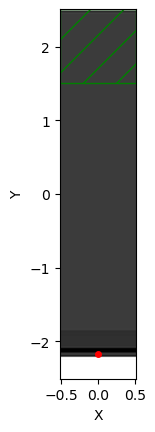

In [1258]:
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

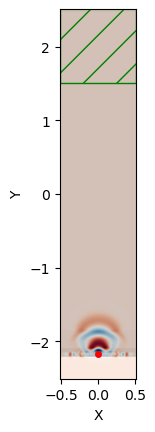

In [1246]:
# sim.reset_meep()

sim.run(until=1)
# sim.plot2D(fields=mp.Ez, output_plane=mp.Volume(center = mp.Vector3(0, centers_y[1]), size = mp.Vector3(1.04, 2)))

sim.plot2D(fields = mp.Ez)

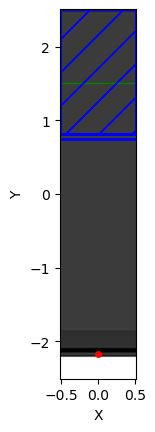

In [1264]:
far_x = [mp.Vector3(0, 1, 0)]

NearRegions = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, 0.75),
        size=mp.Vector3(design_region_width, 0),
        weight=+1,
    )
]

FarFields = mpa.Near2FarFields(sim, NearRegions, far_x)
ob_list = [FarFields]


def J1(FF):
    return npa.mean(npa.abs(FF[0, :, 2]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J1],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)
opt.plot2D(True)

In [1263]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt

# design region 윗면 위치 계산
monitor_y = centers_y[5] + 0.5 * design_region_height + 0.55

# 시뮬레이션 객체 생성
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    k_point=k_point
)

# ⚠ 반드시 먼저 시뮬레이션 초기화
sim.init_sim()

# ✅ 이제 near2far 모니터 등록 (init_sim 이후에 가능)
n2f_obj = sim.add_near2far(
    frequencies[1],  # 중심 주파수
    0,               # bandwidth 없음
    1,               # 주파수 개수
    mp.Near2FarRegion(
        center=mp.Vector3(0, monitor_y, 0),
        size=mp.Vector3(design_region_width, 0, 0),
        direction=mp.Y
    )
)

# 시뮬레이션 실행
sim.run(until_after_sources=mp.stop_when_fields_decayed(
    50, mp.Ez, mp.Vector3(0, monitor_y), 1e-6)
)


KeyboardInterrupt: 

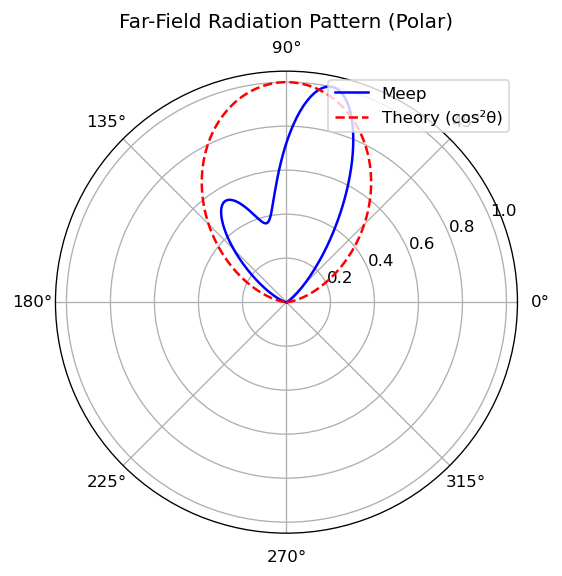

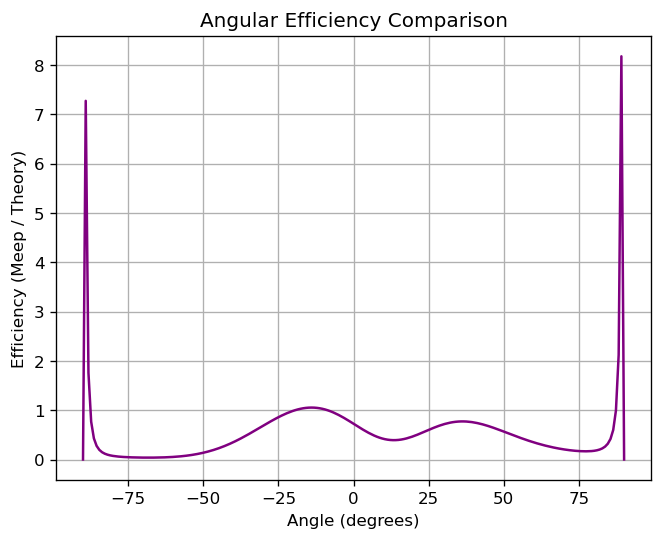

In [537]:
import numpy as np
import matplotlib.pyplot as plt

# θ: -90° ~ +90°
theta_list = np.linspace(-np.pi/2, np.pi/2, 200)
ff_data = []

# Far-field from Meep
for theta in theta_list:
    r = mp.Vector3(30 * np.sin(theta), 30 * np.cos(theta), 0)
    ff = sim.get_farfield(n2f_obj, r)
    ff_data.append(np.abs(ff[2])**2)

ff_data = np.array(ff_data)
ff_data /= np.max(ff_data)  # Meep 결과 정규화

# Theory: dipole radiation pattern ~ cos²θ
theory = np.cos(theta_list)**2
theory /= np.max(theory)  # 동일 스케일로 정규화

# -------------------------
# ✅ Polar plot: 원형 방사 패턴
# -------------------------
fig1 = plt.figure(figsize=(5, 5), dpi=120)
ax1 = fig1.add_subplot(111, polar=True)
ax1.plot(theta_list + np.pi/2, ff_data, label="Meep", color='blue')
ax1.plot(theta_list + np.pi/2, theory, 'r--', label='Theory (cos²θ)')
ax1.set_title("Far-Field Radiation Pattern (Polar)", va='bottom')
ax1.legend(loc='upper right')
plt.show()

# -------------------------
# ✅ Efficiency plot: Meep / Theory
# -------------------------
efficiency = np.zeros_like(ff_data)
nonzero = theory > 1e-6  # 이론이 0이면 나누지 않기 위해
efficiency[nonzero] = ff_data[nonzero] / theory[nonzero]

fig2, ax2 = plt.subplots(dpi=120)
ax2.plot(np.degrees(theta_list), efficiency, color='purple')
ax2.set_xlabel("Angle (degrees)")
ax2.set_ylabel("Efficiency (Meep / Theory)")
ax2.set_title("Angular Efficiency Comparison")
ax2.grid(True)
plt.show()


▶ Dipole 1/10 at x = -0.520


▶ Dipole 2/10 at x = -0.404


▶ Dipole 3/10 at x = -0.289


▶ Dipole 4/10 at x = -0.173


▶ Dipole 5/10 at x = -0.058


▶ Dipole 6/10 at x = 0.058


▶ Dipole 7/10 at x = 0.173


▶ Dipole 8/10 at x = 0.289


▶ Dipole 9/10 at x = 0.404


▶ Dipole 10/10 at x = 0.520


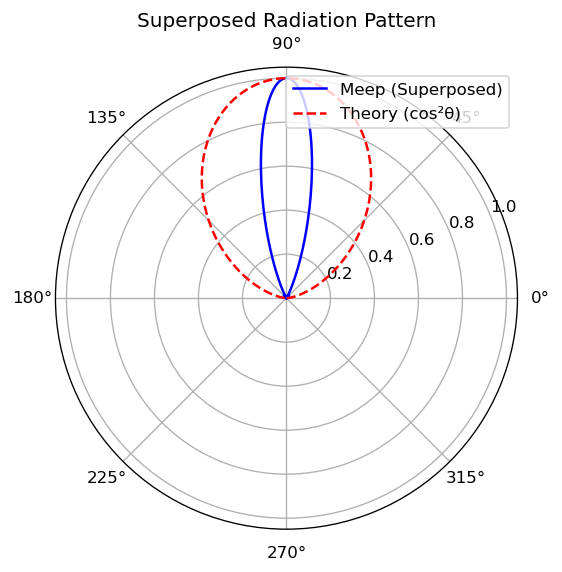

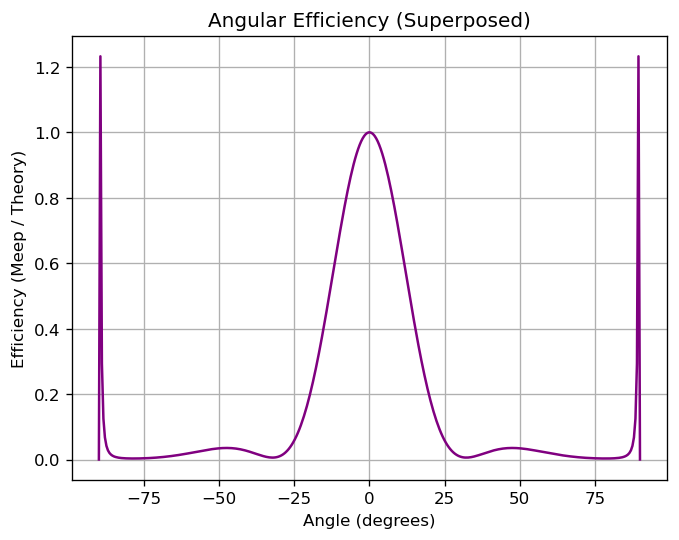

In [248]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt

# 기본 설정
num_dipoles = 10
x_range = design_region_width
x_positions = np.linspace(-0.5 * x_range, 0.5 * x_range, num=num_dipoles)
y_position = centers_y[1]
monitor_y = centers_y[5] + 0.5 * design_region_height + 0.55
theta_list = np.linspace(-np.pi/2, np.pi/2, 360)
far_field_sum = np.zeros_like(theta_list, dtype=complex)  # 누적합 (복소수)

for i, x in enumerate(x_positions):
    print(f"▶ Dipole {i+1}/{num_dipoles} at x = {x:.3f}")

    # 1. 개별 소스
    dipole_source = [mp.Source(
        src=mp.GaussianSource(frequency=frequencies[1], fwidth=frequencies_width),
        component=mp.Ez,
        center=mp.Vector3(x, y_position, 0)
    )]

    # 2. 시뮬레이션 객체
    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=dipole_source,
        resolution=resolution,
        k_point=k_point
    )
    sim.init_sim()

    # 3. Near2Far 모니터 등록
    n2f = sim.add_near2far(
        frequencies[1], 0, 1,
        mp.Near2FarRegion(
            center=mp.Vector3(0, monitor_y),
            size=mp.Vector3(design_region_width, 0, 0),
            direction=mp.Y
        )
    )

    # 4. 시뮬레이션 실행
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ez, mp.Vector3(0, monitor_y), 1e-6)
    )

    # 5. 이 dipole의 far-field 저장 및 누적
    for j, theta in enumerate(theta_list):
        r = mp.Vector3(30 * np.sin(theta), 30 * np.cos(theta), 0)
        ff = sim.get_farfield(n2f, r)
        far_field_sum[j] += ff[2]  # Ez 성분 합성 (복소수)

# 최종 intensity 계산
intensity = np.abs(far_field_sum)**2
intensity /= np.max(intensity)

# 비교 이론 곡선 (cos²θ)
theory = np.cos(theta_list)**2
theory /= np.max(theory)

# ✅ Polar plot
fig1 = plt.figure(figsize=(5, 5), dpi=120)
ax1 = fig1.add_subplot(111, polar=True)
ax1.plot(theta_list + np.pi/2, intensity, label="Meep (Superposed)", color='blue')
ax1.plot(theta_list + np.pi/2, theory, 'r--', label='Theory (cos²θ)')
ax1.set_title("Superposed Radiation Pattern")
ax1.legend(loc='upper right')
plt.show()

# ✅ Efficiency plot
efficiency = np.zeros_like(intensity)
mask = theory > 1e-6
efficiency[mask] = intensity[mask] / theory[mask]

fig2, ax2 = plt.subplots(dpi=120)
ax2.plot(np.degrees(theta_list), efficiency, color='purple')
ax2.set_xlabel("Angle (degrees)")
ax2.set_ylabel("Efficiency (Meep / Theory)")
ax2.set_title("Angular Efficiency (Superposed)")
ax2.grid(True)
plt.show()


<Axes: xlabel='X', ylabel='Y'>

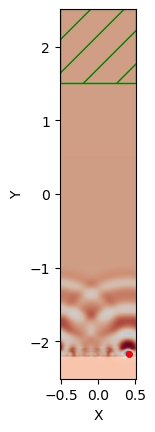

In [561]:
# sim.reset_meep()

sim.run(until=1)
sim.plot2D(fields = mp.Ez)

In [539]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt

num_dipoles = 10
x_range = design_region_width
x_positions = np.linspace(-0.5 * x_range, 0.5 * x_range, num=num_dipoles)
y_position = centers_y[1]
monitor_y = centers_y[5] + 0.5 * design_region_height + 0.55
theta_list = np.linspace(-np.pi/2, np.pi/2, 360)
far_field_sum = np.zeros_like(theta_list, dtype=complex)

for i, x in enumerate(x_positions):
    print(f"▶ Dipole {i+1}/{num_dipoles} at x = {x:.3f}")

    # 개별 소스 정의
    dipole_source = [mp.Source(
        src=mp.GaussianSource(frequency=frequencies[1], fwidth=frequencies_width),
        component=mp.Ez,
        center=mp.Vector3(x, y_position, 0)
    )]

    # 시뮬레이션 객체
    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=dipole_source,
        resolution=resolution,
        k_point=k_point
    )
    sim.init_sim()

    # Near2Far 등록
    n2f = sim.add_near2far(
        frequencies[1], 0, 1,
        mp.Near2FarRegion(
            center=mp.Vector3(0, monitor_y),
            size=mp.Vector3(design_region_width, 0, 0),
            direction=mp.Y
        )
    )

    # 시뮬레이션 실행
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ez, mp.Vector3(0, monitor_y), 1e-6)
    )

    # Far-field 계산
    ff_data = []
    for theta in theta_list:
        r = mp.Vector3(30 * np.sin(theta), 30 * np.cos(theta), 0)
        ff = sim.get_farfield(n2f, r)
        ff_data.append(ff[2])  # 복소수

    ff_data = np.array(ff_data)
    far_field_sum += ff_data  # superposition

    # ✅ 개별 dipole 결과 polar plot 저장
    intensity = np.abs(ff_data)**2
    intensity /= np.max(intensity)

    fig = plt.figure(figsize=(5, 5), dpi=100)
    ax = fig.add_subplot(111, polar=True)
    ax.plot(theta_list + np.pi/2, intensity, label=f"Dipole {i+1}", color='blue')
    ax.set_title(f"Dipole {i+1} Radiation Pattern", va='bottom')
    ax.legend()
    plt.savefig(f"dipole_{i+1:02d}.png", bbox_inches='tight')
    plt.close()


▶ Dipole 1/10 at x = -0.520


▶ Dipole 2/10 at x = -0.404


▶ Dipole 3/10 at x = -0.289


▶ Dipole 4/10 at x = -0.173


▶ Dipole 5/10 at x = -0.058


▶ Dipole 6/10 at x = 0.058


▶ Dipole 7/10 at x = 0.173


▶ Dipole 8/10 at x = 0.289


▶ Dipole 9/10 at x = 0.404


▶ Dipole 10/10 at x = 0.520


In [546]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt

# ===== 파라미터 설정 =====
num_dipoles = 10
design_margin = 0.1  # design region의 10%를 양쪽 margin으로 남김
effective_width = design_region_width * (1 - 2 * design_margin)
x_positions = np.linspace(-0.5 * effective_width, 0.5 * effective_width, num=num_dipoles)
y_position = centers_y[1]  # alq3 중심층
monitor_y = centers_y[5] + 0.5 * design_region_height + 0.55
theta_list = np.linspace(-np.pi/2, np.pi/2, 360)
ff_data_list = []

# 중심 파장 및 파수
wavelength = wavelengths[1]  # 중심 파장 (green)
k = 2 * np.pi / wavelength   # 파수

print("Dipole X 위치:", np.round(x_positions, 3))

# ===== dipole 별 시뮬레이션 수행 =====
for i, x in enumerate(x_positions):
    print(f"▶ Dipole {i+1}/{num_dipoles} at x = {x:.3f}")

    # dipole source 정의
    dipole_source = [mp.Source(
        src=mp.GaussianSource(frequency=frequencies[1], fwidth=frequencies_width),
        component=mp.Ez,
        center=mp.Vector3(x, y_position, 0)
    )]

    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=dipole_source,
        resolution=resolution,
        k_point=k_point
    )
    sim.init_sim()

    n2f = sim.add_near2far(
        frequencies[1], 0, 1,
        mp.Near2FarRegion(
            center=mp.Vector3(0, monitor_y),
            size=mp.Vector3(design_region_width, 0, 0),
            direction=mp.Y
        )
    )

    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ez, mp.Vector3(0, monitor_y), 1e-6)
    )

    # far-field 계산
    ff_data = []
    for theta in theta_list:
        r = mp.Vector3(30 * np.sin(theta), 30 * np.cos(theta), 0)
        ff = sim.get_farfield(n2f, r)
        ff_data.append(ff[2])  # Ez 복소수

    ff_data = np.array(ff_data)
    ff_data_list.append(ff_data)

    # dipole 개별 결과 저장
    intensity = np.abs(ff_data)**2
    intensity /= np.max(intensity)

    fig = plt.figure(figsize=(5, 5), dpi=100)
    ax = fig.add_subplot(111, polar=True)
    ax.plot(theta_list + np.pi/2, intensity, label=f"Dipole {i+1}", color='blue')
    ax.set_title(f"Dipole {i+1} Radiation Pattern", va='bottom')
    ax.legend()
    plt.savefig(f"dipole_{i+1:02d}.png", bbox_inches='tight')
    plt.close()

# ===== 위치 기반 위상 지연 포함한 Superposition =====
superposed_field = np.zeros_like(theta_list, dtype=complex)

for x, ff in zip(x_positions, ff_data_list):
    phase_shift = np.exp(1j * k * x * np.sin(theta_list))  # 위상 지연 적용
    superposed_field += ff * phase_shift

superposed_intensity = np.abs(superposed_field)**2
superposed_intensity /= np.max(superposed_intensity)

# ===== 최종 결과 저장 =====
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot(111, polar=True)
ax.plot(theta_list + np.pi/2, superposed_intensity, color='blue', label="Meep (Superposed)")
ax.set_title("Superposed Radiation Pattern", va='bottom')

# 이론 곡선 (cos²θ)
theory = np.cos(theta_list)**2
theory /= np.max(theory)
ax.plot(theta_list + np.pi/2, theory, 'r--', label='Theory (cos²θ)')

# ±30도 선 추가
for deg in [-30, 30]:
    theta_rad = np.radians(deg) + np.pi/2
    ax.plot([theta_rad, theta_rad], [0, 1.1], 'k--', lw=1.2)

ax.legend(loc='upper right')
plt.savefig("superposed_radiation.png", bbox_inches='tight')
plt.close()


Dipole X 위치: [-0.416 -0.324 -0.231 -0.139 -0.046  0.046  0.139  0.231  0.324  0.416]
▶ Dipole 1/10 at x = -0.416


▶ Dipole 2/10 at x = -0.324


▶ Dipole 3/10 at x = -0.231


▶ Dipole 4/10 at x = -0.139


▶ Dipole 5/10 at x = -0.046


▶ Dipole 6/10 at x = 0.046


▶ Dipole 7/10 at x = 0.139


▶ Dipole 8/10 at x = 0.231


▶ Dipole 9/10 at x = 0.324


▶ Dipole 10/10 at x = 0.416


<Axes: xlabel='X', ylabel='Y'>

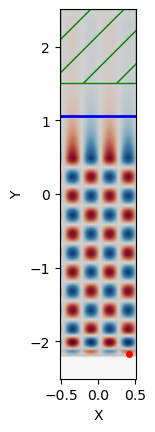

In [548]:
sim.plot2D(fields = mp.Ez)

In [ ]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt

# ===== 파라미터 설정 =====
num_dipoles = 10
design_margin = 0.1  # design region의 10%를 양쪽 margin으로 남김
effective_width = design_region_width * (1 - 2 * design_margin)
x_positions = np.linspace(-0.5 * effective_width, 0.5 * effective_width, num=num_dipoles)
y_position = centers_y[1]  # alq3 중심층
monitor_y = centers_y[5] + 0.5 * design_region_height + 0.55
theta_list = np.linspace(-np.pi/2, np.pi/2, 360)
ff_data_list = []

# 중심 파장 및 파수
wavelength = wavelengths[1]  # 중심 파장 (green)
k = 2 * np.pi / wavelength   # 파수

print("Dipole X 위치:", np.round(x_positions, 3))

# ===== dipole 별 시뮬레이션 수행 =====
for i, x in enumerate(x_positions):
    print(f"▶ Dipole {i+1}/{num_dipoles} at x = {x:.3f}")

    # dipole source 정의
    dipole_source = [mp.Source(
        src=mp.GaussianSource(frequency=frequencies[1], fwidth=frequencies_width),
        component=mp.Ez,
        center=mp.Vector3(x, y_position, 0)
    )]

    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=dipole_source,
        resolution=resolution,
        k_point=k_point
    )
    sim.init_sim()

    n2f = sim.add_near2far(
        frequencies[1], 0, 1,
        mp.Near2FarRegion(
            center=mp.Vector3(0, monitor_y),
            size=mp.Vector3(design_region_width, 0, 0),
            direction=mp.Y
        )
    )

    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ez, mp.Vector3(0, monitor_y), 1e-6)
    )

    # far-field 계산
    ff_data = []
    for theta in theta_list:
        r = mp.Vector3(30 * np.sin(theta), 30 * np.cos(theta), 0)
        ff = sim.get_farfield(n2f, r)
        ff_data.append(ff[2])  # Ez 복소수

    ff_data = np.array(ff_data)
    ff_data_list.append(ff_data)

    # 개별 dipole plot 저장 (정규화는 유지)
    intensity = np.abs(ff_data)**2
    intensity /= np.max(intensity)

    fig = plt.figure(figsize=(5, 5), dpi=100)
    ax = fig.add_subplot(111, polar=True)
    ax.plot(theta_list + np.pi/2, intensity, label=f"Dipole {i+1}", color='blue')
    ax.set_title(f"Dipole {i+1} Radiation Pattern", va='bottom')
    ax.legend()
    plt.savefig(f"dipole_{i+1:02d}.png", bbox_inches='tight')
    plt.close()

# ===== 위상 지연 포함한 Superposition =====
superposed_field = np.zeros_like(theta_list, dtype=complex)

for x, ff in zip(x_positions, ff_data_list):
    phase_shift = np.exp(1j * k * x * np.sin(theta_list))  # 위치 기반 위상 지연
    superposed_field += ff * phase_shift

superposed_intensity = np.abs(superposed_field)**2  # ✅ 정규화하지 않음

# ===== 최종 결과 저장 =====
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot(111, polar=True)
ax.plot(theta_list + np.pi/2, superposed_intensity, color='blue', label="Meep (Superposed)")
ax.set_title("Superposed Radiation Pattern", va='bottom')

# 이론 곡선 (cos²θ, 정규화)
theory = np.cos(theta_list)**2
theory /= np.max(theory)
ax.plot(theta_list + np.pi/2, theory, 'r--', label='Theory (cos²θ)')

# ±30도 선 추가
for deg in [-30, 30]:
    theta_rad = np.radians(deg) + np.pi/2
    ax.plot([theta_rad, theta_rad], [0, np.max(superposed_intensity)*1.05], 'k--', lw=1.2)

ax.legend(loc='upper right')
plt.savefig("superposed_radiation_raw.png", bbox_inches='tight')
plt.close()


Dipole X 위치: [-0.416 -0.324 -0.231 -0.139 -0.046  0.046  0.139  0.231  0.324  0.416]
▶ Dipole 1/10 at x = -0.416


▶ Dipole 2/10 at x = -0.324


▶ Dipole 3/10 at x = -0.231


▶ Dipole 4/10 at x = -0.139


▶ Dipole 5/10 at x = -0.046


▶ Dipole 6/10 at x = 0.046


▶ Dipole 7/10 at x = 0.139


▶ Dipole 8/10 at x = 0.231


▶ Dipole 9/10 at x = 0.324


▶ Dipole 10/10 at x = 0.416


In [555]:
# ===== 각도별 방사 효율 비교 (선형 plot, % 단위) =====

# θ 리스트 (degree) 및 intensity
theta_deg = np.degrees(theta_list)
meep_eff = superposed_intensity
theory_eff = np.cos(theta_list)**2
theory_eff[theory_eff < 0] = 0

# 정규화 없이 %로 맞추기
theory_eff *= np.max(meep_eff)
meep_eff_percent = 100 * meep_eff / np.max(meep_eff)
theory_eff_percent = 100 * theory_eff / np.max(meep_eff)

# Plot
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(theta_deg, meep_eff_percent, label='Meep Result', color='blue', linewidth=2)
plt.plot(theta_deg, theory_eff_percent, 'r--', label='Theory (cos²θ)', linewidth=2)
plt.axvline(x=30, linestyle='--', color='gray', lw=1)
plt.axvline(x=-30, linestyle='--', color='gray', lw=1)

plt.xlabel("Angle (degrees)")
plt.ylabel("Radiation Intensity [%]")
plt.title("Angular Radiation Efficiency Comparison")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("angle_efficiency_comparison.png", bbox_inches='tight')
plt.close()
